# Comparing Logistic Regression, Decision Tree, KNN and SVC models
### Bank Marketing - UCI ML Repository

In [2]:
import time
import pandas as pd 
import numpy as np
import random

from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, StratifiedKFold
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA  
from sklearn.linear_model import LogisticRegression  
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC  
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from collections import Counter  
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable 

from ucimlrepo import fetch_ucirepo 

seed = 42
random.seed(seed)
np.random.seed(seed)

### Import and pre-process data

In [4]:
path = './'

try:
    X = pd.read_csv(path+'X.csv')
    y = pd.read_csv(path+'y.csv')
    print('Data loaded from directory:', path)
except:
    bank_marketing = fetch_ucirepo(id=222) 
    X = bank_marketing.data.features 
    y = bank_marketing.data.targets 
    print('Data loaded from UCIML')

df = X
df['y'] = y['y']

Data loaded from directory: ./


In [5]:
percents = (df.isna().sum() / len(X)) * 100
formatted_percents = percents.apply(lambda x: f'{x:.2f}%')
print(formatted_percents, '\n')
print(f"Length of DataFrame: {len(df)}", '\n\n')

Unnamed: 0      0.00%
age             0.00%
job             0.64%
marital         0.00%
education       4.11%
default         0.00%
balance         0.00%
housing         0.00%
loan            0.00%
contact        28.80%
day_of_week     0.00%
month           0.00%
duration        0.00%
campaign        0.00%
pdays           0.00%
previous        0.00%
poutcome       81.75%
y               0.00%
dtype: object 

Length of DataFrame: 45211 




In [6]:
df_clean = df.drop(columns = ['poutcome', 'contact'])

In [7]:
df_clean = df_clean.dropna()

In [8]:
print(type(df_clean))
print(len(df))
print(len(df_clean))
print(df_clean.isna().sum().sum())

<class 'pandas.core.frame.DataFrame'>
45211
43193
0


In [9]:
dtype_info = pd.DataFrame({
    'Column': df_clean.columns,
    'Dtype': df_clean.dtypes
})

dtype_info['Unique Values'] = dtype_info['Column'].apply(lambda col: df_clean[col].nunique() if df_clean[col].dtype == 'object' else None)
dtype_info

,Column,Dtype,Unique Values
Unnamed: 0,Unnamed: 0,int64,NaN
age,age,int64,NaN
job,job,object,11.0
marital,marital,object,3.0
education,education,object,3.0
default,default,object,2.0
balance,balance,int64,NaN
housing,housing,object,2.0
loan,loan,object,2.0
day_of_week,day_of_week,int64,NaN


In [10]:
for c in df_clean.columns:
    if df_clean[c].dtype == 'object' or c in ['day_of_week']:
        print(f'{c}: \n{sorted(df_clean[c].unique())}', '\n')

job: 
['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed'] 

marital: 
['divorced', 'married', 'single'] 

education: 
['primary', 'secondary', 'tertiary'] 

default: 
['no', 'yes'] 

housing: 
['no', 'yes'] 

loan: 
['no', 'yes'] 

day_of_week: 
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31] 

month: 
['apr', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may', 'nov', 'oct', 'sep'] 



In [11]:
df_clean.rename(columns={'day_of_week': 'day_of_month'}, inplace=True)

In [12]:
object_columns = df_clean.select_dtypes(include=['object']).columns

df_clean['not_previously_contacted'] = (df_clean['pdays'] == -1).astype(int)

df_encoded = pd.get_dummies(df_clean, columns=object_columns, drop_first=True, dtype=float)

print(df_encoded.head())

   Unnamed: 0  age  balance  day_of_month  duration  campaign  pdays  \
0           0   58     2143             5       261         1     -1   
1           1   44       29             5       151         1     -1   
2           2   33        2             5        76         1     -1   
5           5   35      231             5       139         1     -1   
6           6   28      447             5       217         1     -1   

   previous  y  not_previously_contacted  ...  month_dec  month_feb  \
0         0  0                         1  ...        0.0        0.0   
1         0  0                         1  ...        0.0        0.0   
2         0  0                         1  ...        0.0        0.0   
5         0  0                         1  ...        0.0        0.0   
6         0  0                         1  ...        0.0        0.0   

   month_jan  month_jul  month_jun  month_mar  month_may  month_nov  \
0        0.0        0.0        0.0        0.0        1.0        0.0  

In [13]:
X = df_encoded.drop(columns='y')
y = df_encoded['y']

In [14]:
print(X.shape)
print(y.shape)

(43193, 37)
(43193,)


In [15]:
class_mapping = {
    0: 'yes',
    1: 'no'
}

class_distribution = y.value_counts(normalize=True) * 100

print('Class distribution of training data:')
for label, value in class_distribution.items():
    print(f"{class_mapping[label]}: {value:.2f}%")
    
print(f'\nLength of training data: {len(y)}')

Class distribution of training data:
yes: 88.38%
no: 11.62%

Length of training data: 43193


In [16]:
def split_scale_pca(X, y, test_size=0.3, random_state=seed, n_components=None, verbose=True):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    if n_components is not None:
        pca = PCA(n_components=n_components)
    
        X_train_final = pca.fit_transform(X_train_scaled)
        X_test_final = pca.transform(X_test_scaled)

        if verbose:
            print(f"Reduced dimensions: {X_train_final.shape[1]}")
    else:
        X_train_final = X_train_scaled
        X_test_final = X_test_scaled

    if verbose:
        print(f"Train Data Shape: {X_train_final.shape}")
        print(f"Test Data Shape: {X_test_final.shape}")

    return X_train_final, X_test_final, y_train, y_test

In [17]:
X_train, X_test, y_train, y_test = split_scale_pca(X, y, test_size=0.3, random_state=seed, n_components=10, verbose=True)

Reduced dimensions: 10
Train Data Shape: (30235, 10)
Test Data Shape: (12958, 10)


## Training and Evaluation - Full Dataset

In [19]:
param_grids = {
    'Logistic Regression': {
        'model': LogisticRegression(class_weight='balanced', max_iter=1000),
        'params': {'C': [0.1, 1], 'solver': ['liblinear', 'lbfgs']}
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {'max_depth': [5, 10], 'criterion': ['gini', 'entropy']}
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {'n_neighbors': [3, 5], 'weights': ['uniform', 'distance']}
    },
    'SVC': {
        'model': SVC(class_weight='balanced'),
        'params': {'kernel': ['linear', 'rbf'], 'C': [0.1, 1]}
    }
}

train_times = {}
train_accuracies = {name: [] for name in param_grids}
test_accuracies = {name: [] for name in param_grids}
test_preds = {}  # Store test predictions
best_models = {}
metrics = {}

best_test_accuracies = {name: 0 for name in param_grids}

for name, config in param_grids.items():
    print(f'Training {name} with GridSearchCV')

    grid_search = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=ShuffleSplit(n_splits=1, test_size=0.2, random_state=seed), 
        n_jobs=-1, 
        verbose=1
    )

    start_time = time.time()
    grid_search.fit(X_train, y_train)
    elapsed_time = time.time() - start_time
    avg_train_time = elapsed_time / len(grid_search.cv_results_['params'])
    train_times[name] = avg_train_time

    best_model = grid_search.best_estimator_
    best_models[name] = best_model

    y_train_pred = best_model.predict(X_train)
    
    start_time = time.time()
    y_test_pred = best_model.predict(X_test)
    test_time = time.time() - start_time

    test_preds[name] = y_test_pred 

    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_test_pred)

    if accuracy > best_test_accuracies[name]:
        best_test_accuracies[name] = accuracy  
        
        metrics[name] = {
            'accuracy': round(accuracy, 4),
            'precision': round(precision, 4),
            'recall': round(recall, 4),
            'f1': round(f1, 4),
            'avg_train_time (s)': round(avg_train_time, 4),
            'test_time (s)': f"{test_time:.4e}" 
        }

    train_accuracies[name].append(accuracy_score(y_train, y_train_pred))
    test_accuracies[name].append(accuracy)

    print(f'{name} - Best Params: {grid_search.best_params_}')
    print(f'{name} - Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}')
    print(f'{name} - Test Accuracy: {accuracy:.4f}')
    print(f'{name} - Average Train Time: {avg_train_time:.4f} seconds')
    print(f'{name} - Test Time: {test_time:.4e} seconds\n')

metrics_df = pd.DataFrame(metrics)

Training Logistic Regression with GridSearchCV
Fitting 1 folds for each of 4 candidates, totalling 4 fits
Logistic Regression - Best Params: {'C': 0.1, 'solver': 'lbfgs'}
Logistic Regression - Train Accuracy: 0.7460
Logistic Regression - Test Accuracy: 0.7457
Logistic Regression - Average Train Time: 0.9337 seconds
Logistic Regression - Test Time: 0.0000e+00 seconds

Training Decision Tree with GridSearchCV
Fitting 1 folds for each of 4 candidates, totalling 4 fits
Decision Tree - Best Params: {'criterion': 'entropy', 'max_depth': 5}
Decision Tree - Train Accuracy: 0.8864
Decision Tree - Test Accuracy: 0.8829
Decision Tree - Average Train Time: 0.7361 seconds
Decision Tree - Test Time: 8.0299e-04 seconds

Training KNN with GridSearchCV
Fitting 1 folds for each of 4 candidates, totalling 4 fits
KNN - Best Params: {'n_neighbors': 5, 'weights': 'distance'}
KNN - Train Accuracy: 1.0000
KNN - Test Accuracy: 0.8900
KNN - Average Train Time: 0.2898 seconds
KNN - Test Time: 9.0458e-01 seconds


Logistic Regression Model Performance:
Training Accuracy: 0.75
Testing Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.95      0.75      0.84     11452
           1       0.27      0.70      0.39      1506

    accuracy                           0.75     12958
   macro avg       0.61      0.72      0.61     12958
weighted avg       0.87      0.75      0.79     12958

Confusion Matrix:
[[8616 2836]
 [ 459 1047]]

Decision Tree Model Performance:
Training Accuracy: 0.89
Testing Accuracy: 0.88
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     11452
           1       0.48      0.07      0.12      1506

    accuracy                           0.88     12958
   macro avg       0.68      0.53      0.53     12958
weighted avg       0.84      0.88      0.84     12958

Confusion Matrix:
[[11334   118]
 [ 1399   107]]

KNN Model Performance:
Training Accuracy: 1.00
Testing Accuracy: 0.89
              

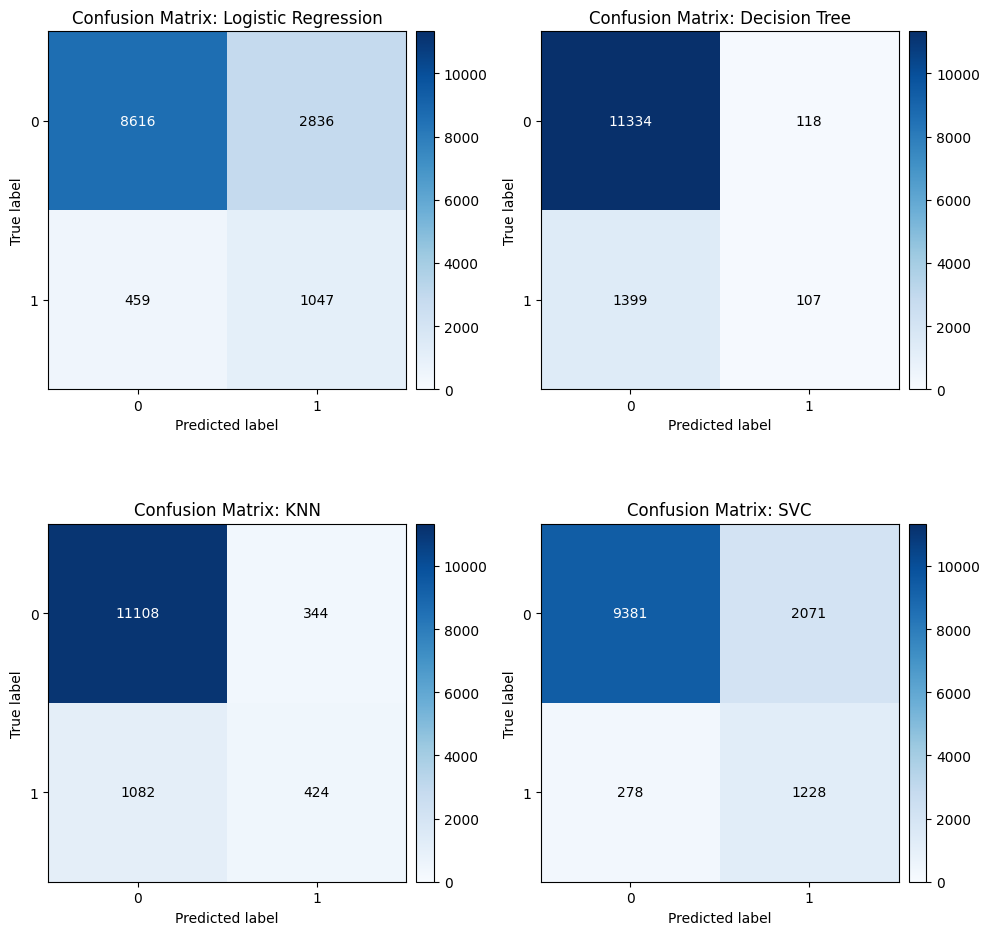

,Logistic Regression,Decision Tree,KNN,SVC
accuracy,0.7457,0.8829,0.89,0.8187
precision,0.8704,0.8419,0.8695,0.9016
recall,0.7457,0.8829,0.89,0.8187
f1,0.7871,0.8427,0.8738,0.8448
avg_train_time (s),0.9337,0.7361,0.2898,27.5199
test_time (s),0.0000e+00,8.0299e-04,9.0458e-01,2.5154e+01


In [20]:
model_names = ['Logistic Regression', 'Decision Tree', 'KNN', 'SVC']  

confusion_matrices = {}
max_value = 0

for name in model_names:
    y_test_pred = test_preds[name]
    cm = confusion_matrix(y_test, y_test_pred)
    confusion_matrices[name] = cm
    max_value = max(max_value, cm.max())  

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()  

for idx, name in enumerate(model_names):
    best_model = best_models[name]  
    train_accuracy = train_accuracies[name]  
    test_accuracy = test_accuracies[name] 

    train_accuracy = train_accuracies[name][-1]  
    test_accuracy = test_accuracies[name][-1]    
    
    print(f'{name} Model Performance:')
    print(f"Training Accuracy: {train_accuracy:.2f}")
    print(f"Testing Accuracy: {test_accuracy:.2f}")
    
    y_test_pred = test_preds[name]

    print(classification_report(y_test, y_test_pred))

    cm = confusion_matrices[name]
    print(f'Confusion Matrix:\n{cm}\n')

    im = axes[idx].imshow(cm, interpolation='nearest', cmap='Blues', vmin=0, vmax=max_value)
    axes[idx].set_title(f'Confusion Matrix: {name}')
    
    axes[idx].set_xticks([0, 1])
    axes[idx].set_yticks([0, 1])
    axes[idx].set_xticklabels(['0', '1'])
    axes[idx].set_yticklabels(['0', '1'])
    axes[idx].set_xlabel('Predicted label')
    axes[idx].set_ylabel('True label')

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[idx].text(j, i, format(cm[i, j], 'd'),
                           ha="center", va="center",
                           color="white" if cm[i, j] > max_value / 2 else "black")  

    divider = make_axes_locatable(axes[idx])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    fig.colorbar(im, cax=cax)

plt.tight_layout()
plt.show()
metrics_df

## Training and Evaluation - Resampled Dataset

In [22]:
param_grids = {
    'Logistic Regression - Resampled': {
        'model': LogisticRegression(class_weight='balanced', max_iter=1000),
        'params': {'C': [0.1, 1], 'solver': ['liblinear', 'lbfgs']}
    },
    'Decision Tree - Resampled': { 
        'model': DecisionTreeClassifier(random_state=42),
        'params': {'max_depth': [5, 10], 'criterion': ['gini', 'entropy']}
    },
    'KNN - Resampled': {
        'model': KNeighborsClassifier(),
        'params': {'n_neighbors': [3, 5], 'weights': ['uniform', 'distance']}
    },
    'SVC - Resampled': {
        'model': SVC(class_weight='balanced'),
        'params': {'kernel': ['linear', 'rbf'], 'C': [0.1, 1]}
    }
}

seeds = [43, 44, 45, 46]

resampled_train_times = {}
resampled_train_accuracies = {name: [] for name in param_grids}
resampled_test_accuracies = {name: [] for name in param_grids}
resampled_test_preds = {}
resampled_best_models = {}
resampled_metrics = {}

best_test_accuracies = {name: 0 for name in param_grids}

for seed in seeds:
    print(f"\n=== Starting Fold with Seed {seed} ===")
    
    undersampler = RandomUnderSampler(random_state=seed)
    X_resampled, y_resampled = undersampler.fit_resample(X, y)

    X_train, X_test, y_train, y_test = split_scale_pca(X_resampled, y_resampled, test_size=0.3, random_state=seed, n_components=10, verbose=False)

    for name, config in param_grids.items():
        print(f'Training {name} with GridSearchCV for seed {seed}')

        grid_search = GridSearchCV(
            estimator=config['model'],
            param_grid=config['params'],
            cv=ShuffleSplit(n_splits=1, test_size=0.2, random_state=seed),
            n_jobs=-1,
            verbose=1
        )

        start_time = time.time()
        grid_search.fit(X_train, y_train)
        elapsed_time = time.time() - start_time
        avg_train_time = elapsed_time / len(grid_search.cv_results_['params'])
        resampled_train_times[f'{name} (Seed {seed})'] = avg_train_time

        best_model = grid_search.best_estimator_
        resampled_best_models[name] = best_model
        y_train_pred = best_model.predict(X_train)

        start_time = time.time()
        y_test_pred = best_model.predict(X_test)
        test_time = time.time() - start_time
        resampled_test_preds[name] = y_test_pred

        precision = precision_score(y_test, y_test_pred, average='weighted')
        recall = recall_score(y_test, y_test_pred, average='weighted')
        f1 = f1_score(y_test, y_test_pred, average='weighted')
        accuracy = accuracy_score(y_test, y_test_pred)

        if accuracy > best_test_accuracies[name]:
            best_test_accuracies[name] = accuracy
            resampled_metrics[name] = {
                'accuracy': round(accuracy, 4),
                'precision': round(precision, 4),
                'recall': round(recall, 4),
                'f1': round(f1, 4),
                'avg_train_time (s)': round(avg_train_time, 4),
                'test_time (s)': f"{test_time:.4e}"
            }

        resampled_train_accuracies[name].append(accuracy_score(y_train, y_train_pred))
        resampled_test_accuracies[name].append(accuracy)

        print(f'{name} (Seed {seed}) - Best Params: {grid_search.best_params_}')
        print(f'{name} (Seed {seed}) - Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}')
        print(f'{name} (Seed {seed}) - Test Accuracy: {accuracy:.4f}')
        print(f'{name} (Seed {seed}) - Average Train Time: {avg_train_time:.4f} seconds')
        print(f'{name} (Seed {seed}) - Test Time: {test_time:.4e} seconds\n')

resampled_metrics_df = pd.DataFrame(resampled_metrics)


=== Starting Fold with Seed 43 ===
Training Logistic Regression - Resampled with GridSearchCV for seed 43
Fitting 1 folds for each of 4 candidates, totalling 4 fits
Logistic Regression - Resampled (Seed 43) - Best Params: {'C': 0.1, 'solver': 'liblinear'}
Logistic Regression - Resampled (Seed 43) - Train Accuracy: 0.7039
Logistic Regression - Resampled (Seed 43) - Test Accuracy: 0.6844
Logistic Regression - Resampled (Seed 43) - Average Train Time: 0.0121 seconds
Logistic Regression - Resampled (Seed 43) - Test Time: 9.9826e-04 seconds

Training Decision Tree - Resampled with GridSearchCV for seed 43
Fitting 1 folds for each of 4 candidates, totalling 4 fits
Decision Tree - Resampled (Seed 43) - Best Params: {'criterion': 'gini', 'max_depth': 10}
Decision Tree - Resampled (Seed 43) - Train Accuracy: 0.8529
Decision Tree - Resampled (Seed 43) - Test Accuracy: 0.6920
Decision Tree - Resampled (Seed 43) - Average Train Time: 0.0499 seconds
Decision Tree - Resampled (Seed 43) - Test Time:

Logistic Regression Model Performance:
Testing Accuracy: 0.59
              precision    recall  f1-score   support

           0       0.93      0.53      0.68     11452
           1       0.16      0.70      0.27      1506

    accuracy                           0.55     12958
   macro avg       0.55      0.61      0.47     12958
weighted avg       0.84      0.55      0.63     12958

Confusion Matrix:
[[6530 4922]
 [ 390 1116]]

Decision Tree Model Performance:
Testing Accuracy: 0.48
              precision    recall  f1-score   support

           0       0.93      0.53      0.68     11452
           1       0.16      0.70      0.27      1506

    accuracy                           0.55     12958
   macro avg       0.55      0.61      0.47     12958
weighted avg       0.84      0.55      0.63     12958

Confusion Matrix:
[[5108 6344]
 [ 361 1145]]

KNN Model Performance:
Testing Accuracy: 0.55
              precision    recall  f1-score   support

           0       0.93      0.53  

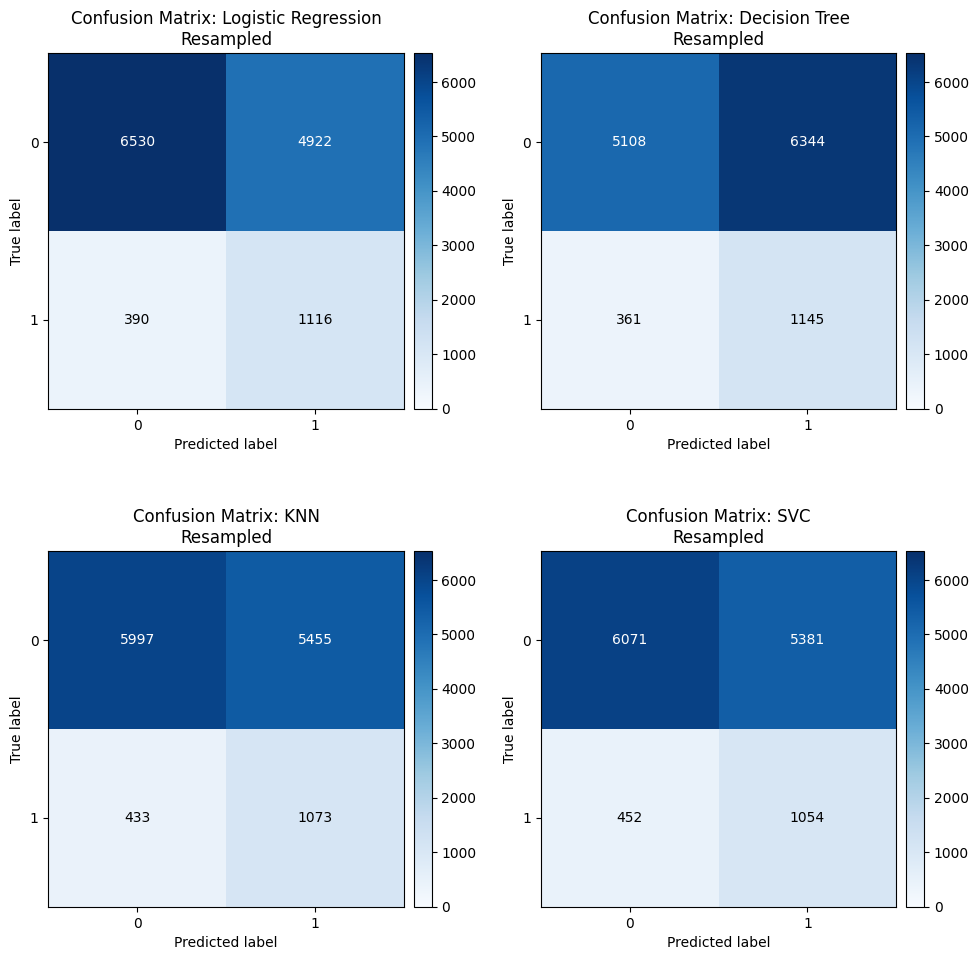

,Logistic Regression - Resampled,Decision Tree - Resampled,KNN - Resampled,SVC - Resampled
accuracy,0.6943,0.7192,0.7282,0.7527
precision,0.6948,0.7193,0.7292,0.7554
recall,0.6943,0.7192,0.7282,0.7527
f1,0.6941,0.7192,0.7279,0.7521
avg_train_time (s),0.0102,0.0723,0.0666,1.6957
test_time (s),0.0000e+00,0.0000e+00,1.4258e-01,2.0157e+00


In [23]:
model_names = ['Logistic Regression', 'Decision Tree', 'KNN', 'SVC'] 

X_train, X_test, y_train, y_test = split_scale_pca(X, y, test_size=0.3, random_state=seed, n_components=10, verbose=False)

confusion_matrices = {}
test_accuracies = {}

max_value = 0

for name in model_names:
    best_model = resampled_best_models[name + ' - Resampled'] 
    
    start_time = time.time()
    y_test_pred = best_model.predict(X_test)
    test_time = time.time() - start_time
    
    cm = confusion_matrix(y_test, y_test_pred)
    confusion_matrices[name] = cm

    test_accuracies[name] = accuracy_score(y_test, y_test_pred)

    max_value = max(max_value, cm.max())

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten() 

for idx, name in enumerate(model_names):
    cm = confusion_matrices[name]  
    test_accuracy = test_accuracies[name] 

    print(f'{name} Model Performance:') 
    print(f"Testing Accuracy: {test_accuracy:.2f}")
    
    print(classification_report(y_test, y_test_pred))

    print(f'Confusion Matrix:\n{cm}\n')

    im = axes[idx].imshow(cm, interpolation='nearest', cmap='Blues', vmin=0, vmax=max_value)  

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[idx].text(j, i, format(cm[i, j], 'd'),
                           ha="center", va="center",
                           color="white" if cm[i, j] > max_value / 2 else "black") 

    axes[idx].set_title(f'Confusion Matrix: {name}\nResampled')
    axes[idx].set_xticks([0, 1])
    axes[idx].set_yticks([0, 1])
    axes[idx].set_xticklabels(['0', '1'])
    axes[idx].set_yticklabels(['0', '1'])
    axes[idx].set_xlabel('Predicted label')
    axes[idx].set_ylabel('True label')

    divider = make_axes_locatable(axes[idx])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    fig.colorbar(im, cax=cax)


plt.tight_layout()
plt.subplots_adjust(top=0.9, hspace=0.4)  
plt.show()

resampled_metrics_df

## SMOTE

In [25]:
param_grids = {
    'Logistic Regression - SMOTE': {
        'model': LogisticRegression(class_weight='balanced', max_iter=1000),
        'params': {'C': [0.1, 1], 'solver': ['liblinear', 'lbfgs']}
    },
    'Decision Tree - SMOTE': { 
        'model': DecisionTreeClassifier(random_state=42),
        'params': {'max_depth': [5, 10], 'criterion': ['gini', 'entropy']}
    },
    'KNN - SMOTE': {
        'model': KNeighborsClassifier(),
        'params': {'n_neighbors': [3, 5], 'weights': ['uniform', 'distance']}
    },
    'SVC - SMOTE': {
        'model': SVC(class_weight='balanced'),
        'params': {'kernel': ['linear', 'rbf'], 'C': [0.1, 1]}
    }
}

seeds = [43, 44, 45, 46]

smote_train_times = {}
smote_train_accuracies = {name: [] for name in param_grids}
smote_test_accuracies = {name: [] for name in param_grids}
smote_test_preds = {}
smote_best_models = {}
smote_metrics = {}

best_test_accuracies = {name: 0 for name in param_grids}

for seed in seeds:
    print(f"\n=== Starting Fold with Seed {seed} ===")
    
    X_train, X_test, y_train, y_test = split_scale_pca(X, y, test_size=0.3, random_state=seed, n_components=10, verbose=False)
    
    smote = SMOTE(random_state=seed)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    for name, config in param_grids.items():
        print(f'Training {name} with GridSearchCV for seed {seed}')

        grid_search = GridSearchCV(
            estimator=config['model'],
            param_grid=config['params'],
            cv=ShuffleSplit(n_splits=1, test_size=0.2, random_state=seed),
            n_jobs=-1,
            verbose=1
        )

        start_time = time.time()
        grid_search.fit(X_train_resampled, y_train_resampled)
        elapsed_time = time.time() - start_time
        avg_train_time = elapsed_time / len(grid_search.cv_results_['params'])
        smote_train_times[f'{name} (Seed {seed})'] = avg_train_time

        best_model = grid_search.best_estimator_
        smote_best_models[name] = best_model
        y_train_pred = best_model.predict(X_train)

        start_time = time.time()
        y_test_pred = best_model.predict(X_test)
        test_time = time.time() - start_time
        smote_test_preds[name] = y_test_pred

        precision = precision_score(y_test, y_test_pred, average='weighted')
        recall = recall_score(y_test, y_test_pred, average='weighted')
        f1 = f1_score(y_test, y_test_pred, average='weighted')
        accuracy = accuracy_score(y_test, y_test_pred)

        if accuracy > best_test_accuracies[name]:
            best_test_accuracies[name] = accuracy
            smote_metrics[name] = {
                'accuracy': round(accuracy, 4),
                'precision': round(precision, 4),
                'recall': round(recall, 4),
                'f1': round(f1, 4),
                'avg_train_time (s)': round(avg_train_time, 4),
                'test_time (s)': f"{test_time:.4e}"
            }

        smote_train_accuracies[name].append(accuracy_score(y_train, y_train_pred))
        smote_test_accuracies[name].append(accuracy)

        print(f'{name} (Seed {seed}) - Best Params: {grid_search.best_params_}')
        print(f'{name} (Seed {seed}) - Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}')
        print(f'{name} (Seed {seed}) - Test Accuracy: {accuracy:.4f}')
        print(f'{name} (Seed {seed}) - Average Train Time: {avg_train_time:.4f} seconds')
        print(f'{name} (Seed {seed}) - Test Time: {test_time:.4e} seconds\n')

smote_metrics_df = pd.DataFrame(smote_metrics)

for name in param_grids:
    avg_train_acc = sum(smote_train_accuracies[name]) / len(smote_train_accuracies[name]) if len(smote_train_accuracies[name]) > 0 else 0
    avg_test_acc = sum(smote_test_accuracies[name]) / len(smote_test_accuracies[name]) if len(smote_test_accuracies[name]) > 0 else 0

    print(f'\n=== Summary for {name} ===')
    print(f'Average Train Accuracy: {avg_train_acc:.4f}')
    print(f'Average Test Accuracy: {avg_test_acc:.4f}')

print(smote_metrics_df)


=== Starting Fold with Seed 43 ===
Training Logistic Regression - SMOTE with GridSearchCV for seed 43
Fitting 1 folds for each of 4 candidates, totalling 4 fits
Logistic Regression - SMOTE (Seed 43) - Best Params: {'C': 0.1, 'solver': 'liblinear'}
Logistic Regression - SMOTE (Seed 43) - Train Accuracy: 0.7541
Logistic Regression - SMOTE (Seed 43) - Test Accuracy: 0.7542
Logistic Regression - SMOTE (Seed 43) - Average Train Time: 0.1091 seconds
Logistic Regression - SMOTE (Seed 43) - Test Time: 1.9963e-03 seconds

Training Decision Tree - SMOTE with GridSearchCV for seed 43
Fitting 1 folds for each of 4 candidates, totalling 4 fits
Decision Tree - SMOTE (Seed 43) - Best Params: {'criterion': 'gini', 'max_depth': 10}
Decision Tree - SMOTE (Seed 43) - Train Accuracy: 0.8162
Decision Tree - SMOTE (Seed 43) - Test Accuracy: 0.7625
Decision Tree - SMOTE (Seed 43) - Average Train Time: 0.5834 seconds
Decision Tree - SMOTE (Seed 43) - Test Time: 2.9581e-03 seconds

Training KNN - SMOTE with G

Logistic Regression (SMOTE) Model Performance:
Testing Accuracy: 0.72
              precision    recall  f1-score   support

           0       0.94      0.76      0.84     11452
           1       0.26      0.65      0.37      1506

    accuracy                           0.75     12958
   macro avg       0.60      0.71      0.61     12958
weighted avg       0.86      0.75      0.79     12958

Confusion Matrix:
[[8391 3061]
 [ 504 1002]]

Decision Tree (SMOTE) Model Performance:
Testing Accuracy: 0.68
              precision    recall  f1-score   support

           0       0.94      0.76      0.84     11452
           1       0.26      0.65      0.37      1506

    accuracy                           0.75     12958
   macro avg       0.60      0.71      0.61     12958
weighted avg       0.86      0.75      0.79     12958

Confusion Matrix:
[[7790 3662]
 [ 487 1019]]

KNN (SMOTE) Model Performance:
Testing Accuracy: 0.74
              precision    recall  f1-score   support

           

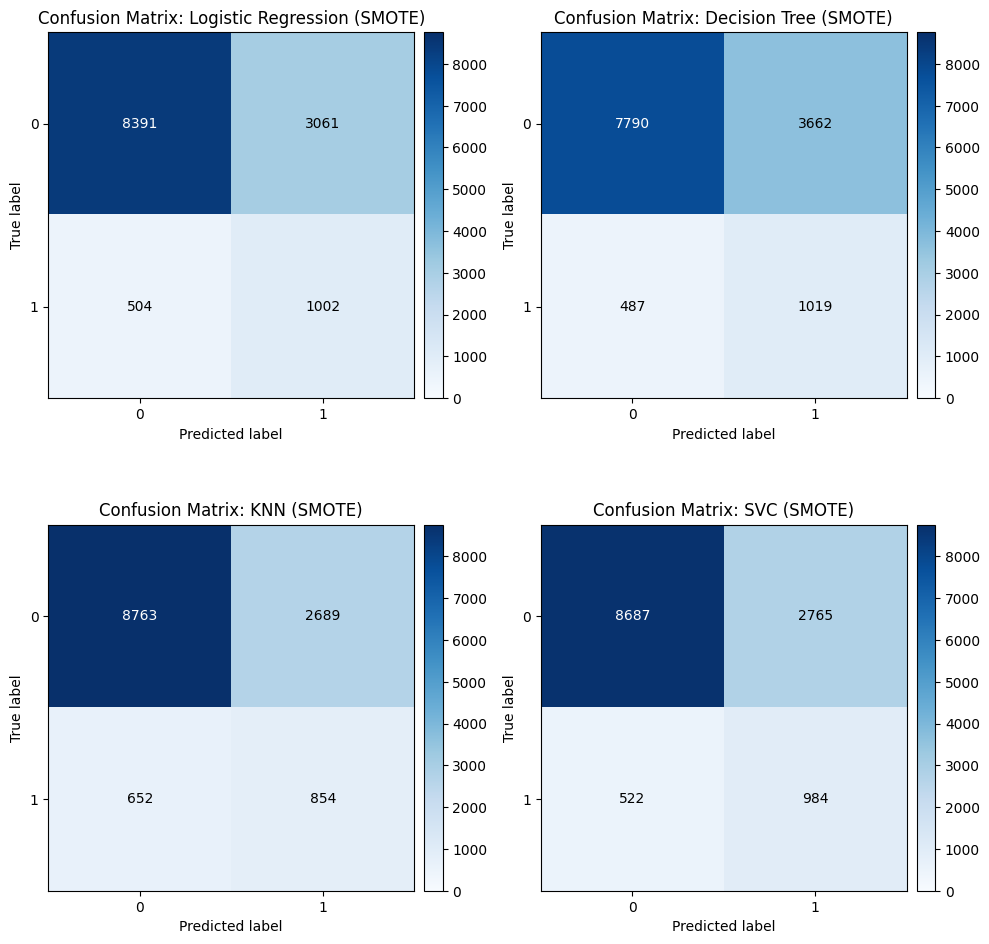

In [26]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

model_names = ['Logistic Regression (SMOTE)', 'Decision Tree (SMOTE)', 'KNN (SMOTE)', 'SVC (SMOTE)']

X_train, X_test, y_train, y_test = split_scale_pca(X, y, test_size=0.3, random_state=seed, n_components=10, verbose=False)

confusion_matrices = {}
test_accuracies = {}

max_value = 0

for name in model_names:
    best_model = smote_best_models[name.replace(' (SMOTE)', ' - SMOTE')]

    y_test_pred = best_model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_test_pred)
    confusion_matrices[name] = cm

    test_accuracies[name] = accuracy_score(y_test, y_test_pred)

    max_value = max(max_value, cm.max())

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()  

for idx, name in enumerate(model_names):
    cm = confusion_matrices[name]  
    test_accuracy = test_accuracies[name]  

    print(f'{name} Model Performance:')
    print(f"Testing Accuracy: {test_accuracy:.2f}")

    print(classification_report(y_test, y_test_pred))

    print(f'Confusion Matrix:\n{cm}\n')

    im = axes[idx].imshow(cm, interpolation='nearest', cmap='Blues', vmin=0, vmax=max_value)
    axes[idx].set_title(f'Confusion Matrix: {name}')
    
    axes[idx].set_xticks([0, 1])
    axes[idx].set_yticks([0, 1])
    axes[idx].set_xticklabels(['0', '1'])
    axes[idx].set_yticklabels(['0', '1'])
    axes[idx].set_xlabel('Predicted label')
    axes[idx].set_ylabel('True label')

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[idx].text(j, i, format(cm[i, j], 'd'),
                           ha="center", va="center",
                           color="white" if cm[i, j] > max_value / 2 else "black")  

    divider = make_axes_locatable(axes[idx])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    fig.colorbar(im, cax=cax)

plt.tight_layout()
plt.show()

In [27]:
def extract_and_clean_metrics(df, metric_name):
    metric_df = df.loc[metric_name].to_frame().T
    metric_df.columns = [col.split(" - ")[0] for col in metric_df.columns]
    return metric_df


accuracy_df = pd.concat([
    extract_and_clean_metrics(metrics_df, 'accuracy').assign(Training_Type='Full'),
    extract_and_clean_metrics(resampled_metrics_df, 'accuracy').assign(Training_Type='Resampled'),
    extract_and_clean_metrics(smote_metrics_df, 'accuracy').assign(Training_Type='SMOTE')
])

precision_df = pd.concat([
    extract_and_clean_metrics(metrics_df, 'precision').assign(Training_Type='Full'),
    extract_and_clean_metrics(resampled_metrics_df, 'precision').assign(Training_Type='Resampled'),
    extract_and_clean_metrics(smote_metrics_df, 'precision').assign(Training_Type='SMOTE')
])

recall_df = pd.concat([
    extract_and_clean_metrics(metrics_df, 'recall').assign(Training_Type='Full'),
    extract_and_clean_metrics(resampled_metrics_df, 'recall').assign(Training_Type='Resampled'),
    extract_and_clean_metrics(smote_metrics_df, 'recall').assign(Training_Type='SMOTE')
])

f1_df = pd.concat([
    extract_and_clean_metrics(metrics_df, 'f1').assign(Training_Type='Full'),
    extract_and_clean_metrics(resampled_metrics_df, 'f1').assign(Training_Type='Resampled'),
    extract_and_clean_metrics(smote_metrics_df, 'f1').assign(Training_Type='SMOTE')
])

avg_train_time_df = pd.concat([
    extract_and_clean_metrics(metrics_df, 'avg_train_time (s)').assign(Training_Type='Full'),
    extract_and_clean_metrics(resampled_metrics_df, 'avg_train_time (s)').assign(Training_Type='Resampled'),
    extract_and_clean_metrics(smote_metrics_df, 'avg_train_time (s)').assign(Training_Type='SMOTE')
])

test_time_df = pd.concat([
    extract_and_clean_metrics(metrics_df, 'test_time (s)').assign(Training_Type='Full'),
    extract_and_clean_metrics(resampled_metrics_df, 'test_time (s)').assign(Training_Type='Resampled'),
    extract_and_clean_metrics(smote_metrics_df, 'test_time (s)').assign(Training_Type='SMOTE')
])

def finalize_metric_df(df):
    df = df.set_index('Training_Type').T
    df.columns.name = 'Training_Type'
    return df


accuracy_df = finalize_metric_df(accuracy_df)
precision_df = finalize_metric_df(precision_df)
recall_df = finalize_metric_df(recall_df)
f1_df = finalize_metric_df(f1_df)
avg_train_time_df = finalize_metric_df(avg_train_time_df)
test_time_df = finalize_metric_df(test_time_df)

print("Accuracy DataFrame:")
print(accuracy_df)
print("\nPrecision DataFrame:")
print(precision_df)
print("\nRecall DataFrame:")
print(recall_df)
print("\nF1 DataFrame:")
print(f1_df)
print("\nAverage Train Time DataFrame:")
print(avg_train_time_df)
print("\nTest Time DataFrame:")
print(test_time_df)

Accuracy DataFrame:
Training_Type          Full Resampled   SMOTE
Logistic Regression  0.7457    0.6943  0.7542
Decision Tree        0.8829    0.7192  0.7974
KNN                    0.89    0.7282  0.8416
SVC                  0.8187    0.7527  0.8308

Precision DataFrame:
Training_Type          Full Resampled   SMOTE
Logistic Regression  0.8704    0.6948  0.8699
Decision Tree        0.8419    0.7193  0.8885
KNN                  0.8695    0.7292  0.8766
SVC                  0.9016    0.7554  0.9055

Recall DataFrame:
Training_Type          Full Resampled   SMOTE
Logistic Regression  0.7457    0.6943  0.7542
Decision Tree        0.8829    0.7192  0.7974
KNN                    0.89    0.7282  0.8416
SVC                  0.8187    0.7527  0.8308

F1 DataFrame:
Training_Type          Full Resampled   SMOTE
Logistic Regression  0.7871    0.6941  0.7932
Decision Tree        0.8427    0.7192  0.8273
KNN                  0.8738    0.7279  0.8555
SVC                  0.8448    0.7521  0.8543

Ave